# 20231117


a=env.action_space.sample() 이렇게하면 엄청 high-frequency component를 가진 녀석이 나온다. Fs=10 N=500을 사용하고 있으므로
-5GHz 에서 5GHz 사이의 component만 가지는 action들로만 action space를 제한 할 수 있을까

또는 저렇게 high frequency component를 가지게 하는 action을 하지 않게 reward 설계해야함 

### low-pass filter?


In [66]:
import envelope
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [67]:
Fs = 10
N = 500
trans_info = [[{'coeff': 1.0, 'amps': 5 * np.array([-0.0154, -0.011, -0.005414]), 'freqs': [6.48e-3, 5.622e-3, 3.7e-3]},
               {'coeff': 0.01, 'amps': 5 * np.array([0.01237, -0.005816, -0.03928]), 'freqs': [0.01758, 0.005925, 0.002652]}],
              [{'coeff': -0.01, 'amps': 5 * np.array([-0.01568, -0.01486, -0.0064]), 'freqs': [0.00737, 0.0072, -0.0039]},
               {'coeff': 1.0, 'amps': 5 * np.array([-0.0154, -0.011, -0.005414]), 'freqs': [6.48e-3, 5.622e-3, 3.7e-3]}]]
A = envelope.flattop(t0=5.,len=10.,amp=1.,w=1.)
B = envelope.flattop(t0=15.,len=30.,amp=0.8,w=1.)
time = np.arange(N) / Fs  # (ns) 
freq = np.fft.fftfreq(N, d=1/Fs) # (GHz)
initial_state = np.hstack((A(time).astype('float32'),B(time).astype('float32'))) 

<ipython-input-67-20ba2ee0f664>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  initial_state = np.hstack((A(time).astype('float32'),B(time).astype('float32')))


In [68]:
A=initial_state[:N]
B=initial_state[N:]
A_=np.fft.fft(initial_state[:N])
B_=np.fft.fft(initial_state[N:])

In [71]:
import gymnasium as gym
import gym_examples

In [72]:
env = gym.make(id='gym_examples/Quantum', Fs=Fs, N=N, initial_state=initial_state,trans_info=trans_info)

In [73]:
a=env.action_space.sample()

In [99]:
f_a=np.fft.fft(a[500:])

<IPython.core.display.Javascript object>


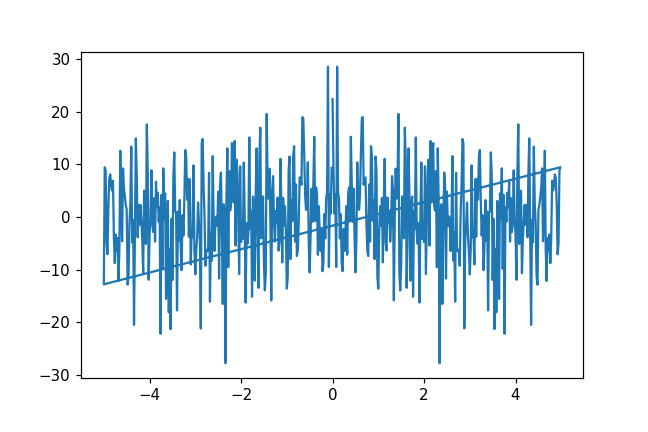

<function matplotlib.pyplot.show(block=None)>

In [101]:
fig, ax = plt.subplots()
ax.plot(freq,f_a.real)
plt.show

<IPython.core.display.Javascript object>


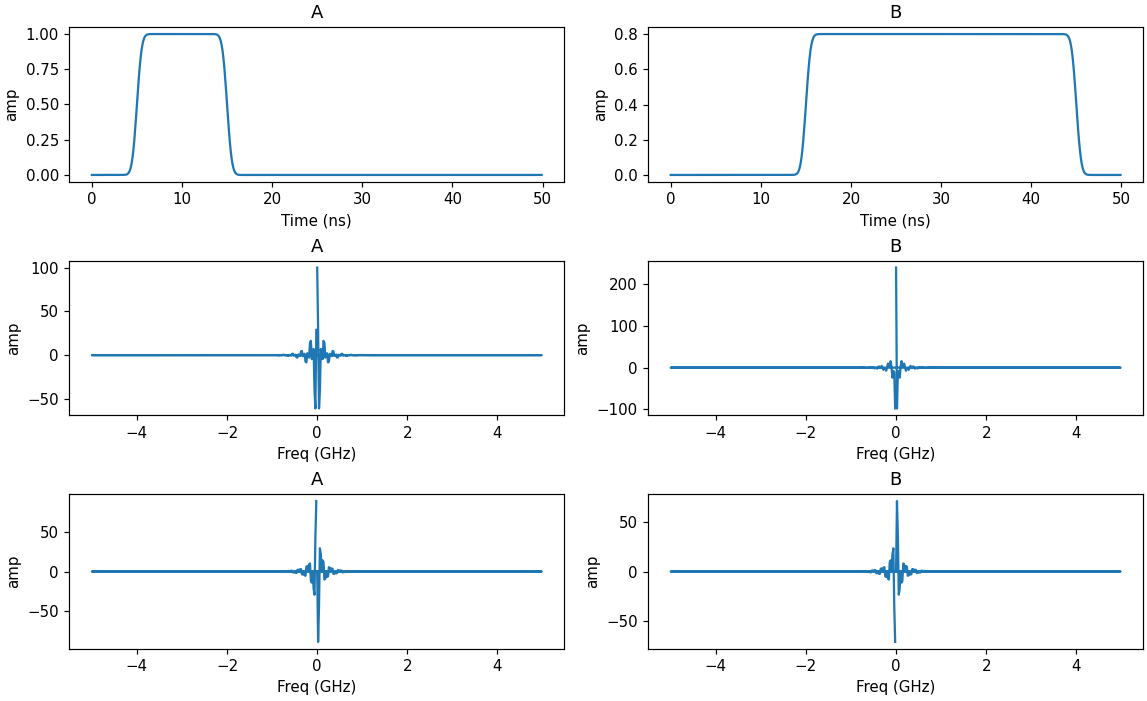

In [80]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18/2.54, 11/2.54), constrained_layout=True)

axes[0, 0].plot(time, A)
axes[0, 0].set_xlabel('Time (ns)')
axes[0, 0].set_ylabel('amp')
axes[0, 0].set_title('A')

axes[0, 1].plot(time, B)
axes[0, 1].set_xlabel('Time (ns)')
axes[0, 1].set_ylabel('amp')
axes[0, 1].set_title('B')

axes[1, 0].plot(freq, A_.real)
axes[1, 0].set_xlabel('Freq (GHz)')
axes[1, 0].set_ylabel('amp')
axes[1, 0].set_title('A')

axes[1, 1].plot(freq, B_.real)
axes[1, 1].set_xlabel('Freq (GHz)')
axes[1, 1].set_ylabel('amp')
axes[1, 1].set_title('B')

axes[2, 0].plot(freq, A_.imag)
axes[2, 0].set_xlabel('Freq (GHz)')
axes[2, 0].set_ylabel('amp')
axes[2, 0].set_title('A')

axes[2, 1].plot(freq, B_.imag)
axes[2, 1].set_xlabel('Freq (GHz)')
axes[2, 1].set_ylabel('amp')
axes[2, 1].set_title('B')

plt.show()

In [74]:
transformer = envelope.ucsb_transformer(transfer_matrix_params=trans_info)
h_matrix = np.array([[transformer.transfer_matrix[i][j](np.pi*2*f) for f in freq] for i in range(2) for j in range(2)]).reshape(2, 2, -1)
h_11, h_12, h_21, h_22 = h_matrix[0][0], h_matrix[0][1], h_matrix[1][0], h_matrix[1][1]

In [75]:
#freq-domain
d_A_ = h_11 * A_ + h_12 * B_  
d_B_ = h_21 * A_ + h_22 * B_

In [76]:
#time-domain
d_A = np.fft.ifft(d_A_).astype("float32") 
d_B = np.fft.ifft(d_B_).astype("float32")

<ipython-input-76-f0cfc3ca92ee>:2: ComplexWarning: Casting complex values to real discards the imaginary part
  d_A = np.fft.ifft(d_A_).astype("float32")
<ipython-input-76-f0cfc3ca92ee>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  d_B = np.fft.ifft(d_B_).astype("float32")


<IPython.core.display.Javascript object>


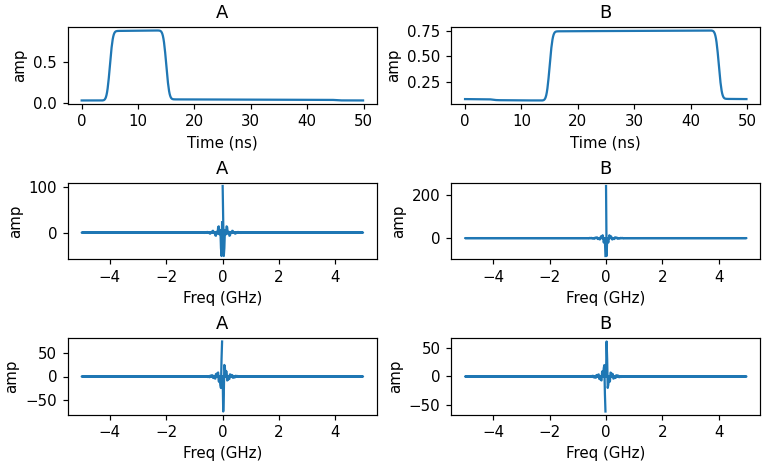

In [79]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18/2.54, 11/2.54), constrained_layout=True)
axes[0, 0].plot(time, d_A)
axes[0, 0].set_xlabel('Time (ns)')
axes[0, 0].set_ylabel('amp')
axes[0, 0].set_title('A')

axes[0, 1].plot(time, d_B)
axes[0, 1].set_xlabel('Time (ns)')
axes[0, 1].set_ylabel('amp')
axes[0, 1].set_title('B')

axes[1, 0].plot(freq, d_A_.real)
axes[1, 0].set_xlabel('Freq (GHz)')
axes[1, 0].set_ylabel('amp')
axes[1, 0].set_title('A')

axes[1, 1].plot(freq, d_B_.real)
axes[1, 1].set_xlabel('Freq (GHz)')
axes[1, 1].set_ylabel('amp')
axes[1, 1].set_title('B')

axes[2, 0].plot(freq, d_A_.imag)
axes[2, 0].set_xlabel('Freq (GHz)')
axes[2, 0].set_ylabel('amp')
axes[2, 0].set_title('A')

axes[2, 1].plot(freq, d_B_.imag)
axes[2, 1].set_xlabel('Freq (GHz)')
axes[2, 1].set_ylabel('amp')
axes[2, 1].set_title('B')

plt.show()

In [106]:
cross_corr = np.sum(A*d_A)

In [105]:
cross_corr

11.219389